## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Univariate feature selection via FDR

In [150]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

ValueError: could not convert string to float: TCGA-91-6849

## Loading TargetScan database for predicted miRNA-targets interactions

In [3]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(tgca_luad.mirna_list) & targetScan_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Loading miRanda database for predicted miRNA-targets interactions

In [4]:
miRanda_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/miRanda_hg19_predictions_S_C_aug2010.txt'), delimiter='\t')
miRanda_df = miRanda_df[['mirna_name',  'gene_symbol']]

miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.lower()
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("*", "")
miRanda_df['mirna_name'] = miRanda_df['mirna_name'].str.replace("-3p.*|-5p.*", "")
print miRanda_df.shape

miRanda_df.columns = ["MiRBase ID", "Gene Symbol"]
miRanda_df = miRanda_df[miRanda_df['MiRBase ID'].isin(tgca_luad.mirna_list) & miRanda_df['Gene Symbol'].isin(tgca_luad.gene_symbols)]
print miRanda_df.shape
putative_assocs = pandas.concat([targetScan_df, miRanda_df]).dropna().drop_duplicates()
print putative_assocs.shape

(1097064, 2)
(815435, 2)


(640757, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [5]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(miRNAs=tgca_luad.mirna_list, targets=tgca_luad.gene_symbols, dys_threshold=0.6)

print network.fit(tag="normal-StgI",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 20
n_B 275


src/models/miRNA_target_network.py:90: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNA_A[m]) * np.std(gene_A[t]))


src/models/miRNA_target_network.py:94: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNA_B[m]) * np.std(gene_B[t]))


21031


In [6]:
network.fit(tag="StgI-StgII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 275
n_B 120


624

In [7]:
network.fit(tag="StgII-StgIII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 120
n_B 84


1503

In [8]:
network.fit(tag="StgIII-StgIV",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=putative_assocs)

n_A 84
n_B 24


src/models/miRNA_target_network.py:90: RuntimeWarning: invalid value encountered in double_scalars
  ((n_A - 1) * np.std(miRNA_A[m]) * np.std(gene_A[t]))
src/models/miRNA_target_network.py:94: RuntimeWarning: invalid value encountered in double_scalars
  ((n_B - 1) * np.std(miRNA_B[m]) * np.std(gene_B[t]))


we got a problem -0.0584695808215 1.01538136541


we got a problem -0.0134505144091 1.01604075879


we got a problem 0.0336869252065 1.00609909201


we got a problem -0.038755080057 1.03284497055
we got a problem -0.0443382395779 1.01026081824
we got a problem -0.0772023308158 1.02455967568
we got a problem -0.0478617788913 1.02431259355
we got a problem -0.0641032652564 1.03489313113


we got a problem 0.00365694552937 1.03963519319


we got a problem -0.0845609037918 1.01174414478
we got a problem -0.0474323587041 1.00906370526


we got a problem -0.0296304235605 1.03179906033


we got a problem 0.003574947954 1.00754230475


we got a problem -0.0337307453753 1.02776430338
we got a problem -0.0293451756266 1.03569909906
we got a problem -0.0331804613764 1.03664499922


we got a problem -0.0418429772017 1.03734089835


we got a problem -0.0384050201065 1.04089877852


we got a problem -0.0679709222169 1.02055256962


we got a problem -0.0516830000323 1.0434304735


we got a problem -0.0945728561027 1.01587476512


we got a problem 0.067341412273 1.03344516726
we got a problem 0.0125578671517 1.01557380577


we got a problem 0.139659706447 1.01229950749
we got a problem -0.00612936289418 1.01943600611
we got a problem 0.168318709322 1.01910740539
we got a problem -0.0487012688579 1.0169573415


we got a problem 0.17912259096 1.02345801372


we got a problem -0.0454292224699 1.04194143501
we got a problem -0.00340391349388 1.04194532398
we got a problem -0.0030539203946 1.04196295947
we got a problem -0.075287639749 1.04166086197
we got a problem 0.327715890957 1.0058335289
we got a problem -0.0536532342218 1.02500801276


we got a problem -0.0297747208205 1.02481505403
we got a problem -0.0271035153266 1.02482000817
we got a problem -0.0283592877782 1.02479849347
we got a problem -0.0459333119663 1.02118728753


we got a problem 0.757534954478 1.01466127026
we got a problem -0.0385590451419 1.0146884037
we got a problem -0.0388286676461 1.014780749
we got a problem 0.0177818002565 1.02561361286
we got a problem 0.17605941306 1.02139795127
we got a problem -0.00906181303132 1.02881759874
we got a problem -0.054448382618 1.01637845227


we got a problem 0.122046861401 1.01481057765
we got a problem -0.0764565384654 1.02649745644
we got a problem -0.0230115075189 1.03060195476


we got a problem -0.0324096666274 1.03064761002
we got a problem 0.0889182225325 1.00707202901


we got a problem 0.0913258792721 1.03036626264
we got a problem -0.00877576415798 1.02262402349
we got a problem -0.0220262788755 1.02109677203


we got a problem 0.000259206908197 1.02651406714
we got a problem -0.0517469414447 1.02405992184
we got a problem 0.141285736275 1.03717540324
we got a problem -0.028715863696 1.03473585059


we got a problem -0.0117298444965 1.00186623227


we got a problem -0.0299968247582 1.00261907237


we got a problem 0.0135713672751 1.02761366188
we got a problem 0.0365634078815 1.03395134983
we got a problem 0.236322343828 1.0040941352
we got a problem 0.0019260363455 1.00970599241


we got a problem 0.662426485507 1.0170240949


we got a problem 0.517282027867 1.01339673621


we got a problem 0.0436877847036 1.01548898498
we got a problem -0.0020408796771 1.03885081626
we got a problem -0.0537941326156 1.03918192118


we got a problem 0.023944078703 1.01088696108
we got a problem 0.0249229669114 1.01127458247
we got a problem 0.0133429960206 1.02658817755
we got a problem 0.00765172875128 1.00523261328


we got a problem 0.0734420689879 1.03395751041
we got a problem 0.155033852024 1.03714709281
we got a problem 0.0712111565827 1.03874275787


we got a problem nan 1.00657271353


we got a problem nan 1.03318587062


we got a problem nan 1.00186832365
we got a problem nan 1.01820722024


we got a problem nan 1.02581743586
we got a problem nan 1.04313773631


we got a problem nan 1.02465929869
we got a problem nan 1.0434593361


we got a problem nan 1.0293753903


we got a problem 1.00717415895 -0.0213163445544


we got a problem 0.078778367125 1.03679484551


we got a problem -0.0315460614129 1.035189215
we got a problem -0.0515839520891 1.00318067577


we got a problem -0.0215980716981 1.01289741948


we got a problem -0.0380211135493 1.02533326542


we got a problem 0.0116307670654 1.02878907856
we got a problem 0.0377926722912 1.01974405712


we got a problem -0.0292833923324 1.00609909201
we got a problem 0.3347397541 1.04307179738


we got a problem 0.127908790451 1.03337511604


we got a problem 0.0315382919592 1.00386835299


we got a problem -0.0318024487688 1.03407801818


we got a problem -0.0188441799427 1.03346343364


we got a problem 0.0820668728831 1.03599070117
we got a problem 0.0337445388899 1.02534707129
we got a problem -0.0701189769014 1.04255170596


we got a problem 0.0550053873126 1.01639976818


we got a problem 0.491808846866 1.02991545791
we got a problem -0.0514791356378 1.00407268003
we got a problem 0.0138332558935 1.03474391929
we got a problem 0.0636745682053 1.02649353787


we got a problem 0.116233147683 1.00599819337
we got a problem 0.150637868594 1.01328438212
we got a problem -0.0535773227621 1.02854119215
we got a problem -0.0176666128313 1.02025874362
we got a problem -0.0251066859131 1.03443232141


we got a problem 0.134489490612 1.01866025242
we got a problem -0.00669230885235 1.01401952265
we got a problem 0.173478905058 1.03026659539


we got a problem 0.0352696141747 1.03435650256
we got a problem -0.020862276915 1.03963174895


we got a problem 0.0736508806104 1.02422201743


we got a problem -0.0952603703281 1.00483766843
we got a problem 0.0292287248862 1.03940362748
we got a problem -0.0144096854565 1.01948341314
we got a problem 0.0999892405975 1.01934173928
we got a problem -0.078767852817 1.03699919026


we got a problem 0.110827214424 1.0261705948
we got a problem -0.069072467873 1.02284084106
we got a problem -0.0442977880079 1.03132727371
we got a problem 0.0946177355972 1.01925979793


we got a problem 0.0317597748631 1.00022462424
we got a problem 0.0253601245218 1.02387529279


we got a problem 0.119708358957 1.00915658747


we got a problem 0.0215147160986 1.00101624773


we got a problem 0.428568839369 1.02177860449
we got a problem 0.651697701097 1.02669917734


we got a problem 0.0562506966996 1.03486160004


we got a problem 1.00373147869 0.457236651358
we got a problem 1.0080553991 0.00952805803634


we got a problem 0.0795160234145 1.0297421428
we got a problem -0.0946190033375 1.01430568542
we got a problem 0.282027667762 1.01732931994
we got a problem 0.0620629411298 1.02031691153


we got a problem 0.354280588127 1.01162577586
we got a problem 0.128997589994 1.02082964957
we got a problem -0.0834242312902 1.0271098431
we got a problem 0.0113855254837 1.00504702341


we got a problem 0.194995147188 1.00853793608


we got a problem -0.0293699053528 1.0337427941
we got a problem -0.057310109084 1.03418472675
we got a problem 0.0326681254317 1.02560451899
we got a problem 0.0436688166463 1.02232399774
we got a problem -0.00864990903181 1.00697785233


we got a problem 0.132667199192 1.02911286568
we got a problem 0.105563948818 1.00977382482


we got a problem 0.0090790301708 1.01732471073


we got a problem 0.0388171699235 1.01374078836
we got a problem 0.302583907047 1.02765870229
we got a problem 

0.231646399421 1.01461821703
we got a problem 0.028307354847 1.01049275124
we got a problem 0.0430379510197 1.03938805344


we got a problem 0.0897071999475 1.02257662648


we got a problem -0.0235737705597 1.02580342836
we got a problem -0.00915329298274 1.02984825661
we got a problem 0.136379236022 1.01923933536
we got a problem 0.22210939211 1.01875212158


we got a problem 1.00732309247 0.179990055044


we got a problem 0.0194385252516 1.01606055763
we got a problem 0.00305026822754 1.02995548043
we got a problem -0.0351367815266 1.00469360958
we got a problem 0.0397610165754 1.03545291201


we got a problem -0.00823596723639 1.00318106642
we got a problem 0.0340079861289 1.00310579598
we got a problem -0.0648831452411 1.01787359498
we got a problem -0.0106586164336 1.03531214937


we got a problem -0.0517423848973 1.0119185347
we got a problem 0.13569448903 1.02299702872


we got a problem -0.01354436074 1.0420943554
we got a problem 0.074227568335 1.00897931135


we got a problem 0.0640778425779 1.00495735485
we got a problem 0.0823279232039 1.0251599107
we got a problem -0.0533972222883 1.00970864669
we got a problem -0.0596382653766 1.03917096473
we got a problem 0.131199151912 1.00828766369
we got a problem 0.0854224537068 

1.03265615469
we got a problem -0.028793575382 1.02344890783
we got a problem -0.0813906816382 1.02288215187
we got a problem 0.0272880954538 1.03790400895
we got a problem -0.000310980261089 1.03414738484


we got a problem 0.0653810024084 1.01660730842


we got a problem 0.258103742407 1.00674915712
we got a problem 0.0254311016632 1.01775554577


we got a problem 0.0393676803013 1.0377807244
we got a problem -0.0191937490942 1.04232880649
we got a problem -0.000492800420714 1.00360650438


we got a problem -0.0171246670293 1.02966108916
we got a problem -0.0279044660901 1.03715496059


we got a problem 0.0871709002262 1.01744656599
we got a problem -0.0340052600798 1.01037404847
we got a problem -0.0572105004462 1.01607149062


we got a problem -0.142287849268 1.0139670767
we got a problem 0.0793764970814 1.00707178461
we got a problem 0.187623041776 1.0187994971
we got a problem -0.0384703233246 1.0229907199


we got a problem 0.0845858824174 1.01710714598


we got a problem 0.127193652655 1.00130338787


we got a problem 0.160073391678 1.01796524848


we got a problem -0.0728449534519 1.00896374069
we got a problem 0.0098295539194 1.02127588134


we got a problem -0.0301127781889 1.0008295058


we got a problem 0.939337584098 1.00330681838
we got a problem 0.310668123463 1.01435803183
we got a problem -0.0230920540305 1.01411501275
we got a problem -0.0264502236224 1.00185815719


we got a problem 0.0408437993078 1.01337184614
we got a problem -0.0272455818035 1.01311444535


we got a problem 0.000716949911794 1.01908020498
we got a problem -0.0412661730303 1.02209771318


we got a problem -0.00294859615789 1.00034704709


we got a problem 0.249038122489 1.02160763408
we got a problem 0.0778308200403 1.02233982179
we got a problem 0.248422744213 1.00444715512


we got a problem 0.317481945937 1.01059900486
we got a problem 0.0640232919869 1.00513442886
we got a problem 0.316456409614 1.01990589566


we got a problem 0.0879353635795 1.01974790773
we got a problem 0.353274309939 1.02230092216


we got a problem 0.0193624554966 1.01598455066


we got a problem 0.160306552988 1.01983451149
we got a problem 0.63160949761 1.0140443277
we got a problem 0.0829730814379 1.00895246295


we got a problem -0.0305231512171 1.01529019363


we got a problem 0.0794330060107 1.01528000512
we got a problem 0.0931736240321 1.0227823409


we got a problem 1.00533064064 0.100723308138


we got a problem 1.00976549 -0.0633624034677
we got a problem 1.00325088605 -0.12907566616


we got a problem 1.00976549 -0.134629633353


we got a problem 1.00449766523 0.0877294199543


we got a problem -0.0160370699204 1.03976297404
we got a problem -0.0606931130505 1.03571757442


we got a problem 0.161316952165 1.04275933579


we got a problem 0.124024192392 1.03354059782
we got a problem -0.0118887594253 1.00358976879
we got a problem -0.0265834400164 1.03466663652
we got a problem 0.196651289005 1.0202990792


we got a problem -0.0165116880801 1.0145662418
we got a problem -0.0604769390215 1.03389583617
we got a problem -0.00316932645615 1.01365365384


we got a problem -0.0496222064852 1.01608752883
we got a problem -0.0560175799022 1.00253380708
we got a problem -0.103553644571 1.03786936378


we got a problem 0.168519731721 1.03674246497
we got a problem -0.0579395635569 1.03946369435
we got a problem 0.301400945948 1.03654767986
we got a problem -0.0594461797896 1.04203664665


we got a problem 0.435490022424 1.03981473789
we got a problem 0.0551228864271 1.03636361422
we got a problem -0.00671773107049 1.0171907536


we got a problem 0.183970999048 1.00302314502
we got a problem 0.0405435260148 1.00295317121
we got a problem -0.0188542954077 1.04243858303
we got a problem 0.00542402908526 1.02789162079
we got a problem 0.253095893075 1.01087630275


we got a problem -0.0910532627277 1.00163696924
we got a problem -0.0286134968399 1.00029820043
we got a problem -0.00582126468725 1.00291854191


we got a problem -0.0781887333131 1.0017930472
we got a problem 0.969408978358 1.01319952275
we got a problem 0.045331971186 1.00044576919


we got a problem -0.0431207110589 1.00039420782


we got a problem -0.163508947768 1.00238981089
we got a problem 0.00639872777578 1.00107507135


we got a problem 0.0414144444964 1.00019031615


we got a problem -0.0723535110709 1.02618252256
we got a problem -0.00886220109313 1.00670358601
we got a problem 0.019215654756 1.03022183293
we got a problem -0.0620189069178 1.02177348613


we got a problem -0.00906563763652 1.01816732998
we got a problem 0.0585224780642 1.03550242516
we got a problem -0.0544420626025 1.01330812127


we got a problem -0.00544718800344 1.03698996486
we got a problem -0.02796915286 1.03668261497
we got a problem -0.108916586887 1.00838613307


we got a problem 0.0679124664028 1.01136156833
we got a problem 0.0317268983365 1.03678314614
we got a problem 0.0235443042791 1.03665490415
we got a problem 0.168246247408 1.00809167833


we got a problem 0.00425244107712 1.00671181154
we got a problem 0.201127968643 1.02744342991


we got a problem 0.0713638099527 1.01526031268
we got a problem 0.010201533698 1.01827374636


we got a problem -0.0585974997585 1.02767767723
we got a problem 0.133968054627 1.02933295132
we got a problem 0.0700258761215 1.03065569651
we got a problem 0.227113520318 1.0253898571


we got a problem 0.00656793019961 1.02561235963
we got a problem -0.0597954450259 1.02802803309


we got a problem -0.112180604501 1.02153931153
we got a problem 0.0992390181724 1.03317341241
we got a problem -0.0366051296104 1.01217739369
we got a problem 0.116867504128 1.0243990503


we got a problem -0.0311248495603 1.00289361685
we got a problem 0.0449919527769 1.01817466205
we got a problem -0.0206130059753 1.02178767978
we got a problem 0.0643062095012 1.02874798367


we got a problem 0.0703955502012 1.02717631343
we got a problem 0.425892664013 1.02481205757
we got a problem 0.28547166745 1.0172876309


we got a problem 0.15247568575 1.04347826087
we got a problem 0.21814559307 1.01377839351


we got a problem -0.0220303248797 1.04346918114
we got a problem 0.00841822388548 1.04346469366
we got a problem -0.0450306849675 1.01955248808


we got a problem 0.575362652251 1.03861862946
we got a problem 0.00199750970697 1.00771364087
we got a problem 0.618794706579 1.00622711397
we got a problem -0.0268633160417 1.02345533578


we got a problem -0.0139546382611 1.04347826087


we got a problem -0.0310954020275 1.04347826087


we got a problem 0.791477637292 1.02689142789
we got a problem 0.598727925074 1.02211725932
we got a problem 0.793034746448 1.00570180057
we got a problem 0.321685959852 1.00800759673
we got a problem 0.564759641085 1.00893713203
we got a problem 0.664261924099 1.00529914425


we got a problem 0.741115274335 1.0271228132


we got a problem 0.811123019835 1.01615965868
we got a problem 0.586705830044 1.01588876666
we got a problem 0.771987284678 1.02557884355
we got a problem 0.790519973755 1.02732520935


we got a problem 0.594493119773 1.02601557681
we got a problem 0.656783473966 1.02007721353


we got a problem 0.721549601418 1.02014111361
we got a problem 0.4879424784 1.0052123419
we got a problem 0.579032533284 1.02128459343
we got a problem 0.675569454168 1.0180370675


we got a problem 0.0430157236857 1.01118679072
we got a problem 0.16320890114 1.03178159258
we got a problem -0.00122842318421 1.036409961
we got a problem nan 1.036409961
we got a problem 0.129120435798 1.00615549055


we got a problem -0.0668688218229 1.00405689606
we got a problem -0.0955745062858 1.03743250624
we got a problem -0.0275551478208 1.01115089316
we got a problem 0.273039791535 1.03860411538
we got a problem 0.207463620925 1.03702666948
we got a problem -0.0308678354553 1.02105175276


we got a problem -0.0387233330639 1.03180384937
we got a problem 0.0685526753668 1.02017699543
we got a problem 0.0946230288815 1.00984780996


we got a problem -0.0350735362059 1.03585678398
we got a problem 0.140214059795 1.02689468272
we got a problem -0.0752890068408 1.00518506719
we got a problem 0.043974748693 1.00167508047


we got a problem -0.0129098204355 1.03231187825
we got a problem 0.0728500927495 1.036409961


we got a problem -0.0745357892184 1.01826390144
we got a problem 0.033953898964 1.03516845297


we got a problem nan 1.02732958551
we got a problem -0.0381524362211 1.02790797932
we got a problem 0.284501179705 1.00659215836


we got a problem 0.0704227379649 1.01228931255
we got a problem -0.0698138204575 1.00802380964
we got a problem 0.0935165501307 1.03082585421


we got a problem 0.0722499785946 1.01714857887
we got a problem 0.0414212797966 1.01640449958
we got a problem -0.023477264292 1.01887784586
we got a problem -0.00553424997733 1.02646245346
we got a problem 0.373954681858 1.01911672468


we got a problem -0.027445469969 1.02591774972
we got a problem 0.074679839588 1.0238854205
we got a problem 0.00313903194105 1.00151576399
we got a problem 0.0195317913524 1.02136103937
we got a problem 0.0209763390853 1.02631998973
we got a problem -0.0847673249873 1.02725093067
we got a problem -0.0518646443721 1.03588751476


we got a problem 0.131332801823 1.01608049816
we got a problem -0.0392083354535 1.02606240268
we got a problem -0.0699187009489 1.03062596094
we got a problem 0.640962153518 1.00868533748
we got a problem -0.0292542182501 1.03269484606


we got a problem -0.00293668567356 1.01095140998
we got a problem 0.0231401782762 1.03144847142
we got a problem 0.102305665265 1.01321665089
we got a problem -0.0316451572895 1.03550483645
we got a problem -0.0217157840969 1.01750439864


we got a problem -0.019428372673 1.00627811851
we got a problem 0.0276067477412 1.02429417765
we got a problem 0.0388136994209 1.02927367557
we got a problem 0.0299082176986 1.02187810653
we got a problem 0.115834344773 1.04089330276


we got a problem 0.201164819615 1.01888029916
we got a problem 0.242613125725 1.01330475801
we got a problem -0.0149956400777 1.0112651542
we got a problem 0.0293206759127 1.0368911659


we got a problem 0.102918695107 1.02517407318
we got a problem 0.0648292886294 1.03637089177
we got a problem 0.0378936245278 1.03933262864
we got a problem 0.00685383551605 1.0167049894
we got a problem 0.0952608190751 1.00524591543


we got a problem -0.117191271408 1.04171158369
we got a problem 0.035465712649 1.0338803604
we got a problem 0.230103136856 1.02595206424
we got a problem -0.0354064505088 1.00609176848


we got a problem -0.0208289747375 1.04347816136


we got a problem -0.0183655596628 1.04346879658
we got a problem -0.0204735770836 1.04346458128
we got a problem -0.0371510796505 1.01954854892


we got a problem -0.0333072392014 1.03861043027
we got a problem -0.0191407312968 1.00770075519
we got a problem 0.0322603953814 1.006241083
we got a problem 0.0173568779699 1.02349164876


we got a problem -0.0217620456777 1.04347816136


we got a problem -0.020776606931 1.03613362652


we got a problem -0.0229366900093 1.04347816136
we got a problem -0.0214506772021 1.04347786423


we got a problem -0.0152626998982 1.01388179433
we got a problem -0.0196238948629 1.04346831793
we got a problem -0.00912061254113 1.0434637956
we got a problem -0.0308496687719 1.01954976682


we got a problem -0.0369667534851 1.03860308933
we got a problem -0.0187589058705 1.00769044128
we got a problem 0.0274680708576 1.00631058692
we got a problem 0.017388465742 1.02357151044


we got a problem -0.0226496785457 1.04347786423


we got a problem -0.0228846869913 1.00431774274


we got a problem -0.0193868960165 1.04347786423


we got a problem -0.0782989427412 1.02707657865
we got a problem -0.0629105779843 1.03144878919


we got a problem 0.0445079325614 1.01812888871
we got a problem -0.0042822087415 1.01192654174
we got a problem -0.0642427416308 1.01557307313
we got a problem 0.534864717606 1.01577639343
we got a problem -0.0261811874086 1.01244004239
we got a problem -0.0774590992473 1.03664565991


we got a problem 0.0676518769247 1.03575330229
we got a problem -0.124036460725 1.01543786745
we got a problem -0.00884886621811 1.02983634332


we got a problem -0.0567000393723 1.03156601645
we got a problem 0.170953270299 1.02736025952
we got a problem 0.0469767493025 1.00698184691
we got a problem 0.0333694757516 1.01834314629
we got a problem 0.0915767224676 1.01707161794


we got a problem 0.0820348919139 1.02218993052
we got a problem -0.003079514237 1.03323719729
we got a problem -0.00366594986043 1.01541711407
we got a problem -0.0242186376586 1.0314175515
we got a problem 0.367344725104 1.02446076273
we got a problem -0.0634764269086 1.02376043529
we got a problem -0.012951907556 1.02849371569
we got a problem -0.0534512415948 1.0181973932


we got a problem 0.0291062488264 1.02428084097
we got a problem -0.0548567942933 1.03671106695
we got a problem -0.0140404268776 1.01049744269
we got a problem 0.265534876881 1.01432646997


we got a problem -0.029921673058 1.02538449442
we got a problem -0.0165274956131 1.03390741227
we got a problem -0.104555261872 1.0357786038
we got a problem -0.0312666008297 1.03259449571
we got a problem 0.0400566863292 1.02024818318
we got a problem -0.050459658791 1.03453505745
we got a problem -0.0407026778627 1.02144765505


we got a problem 0.0364970741147 1.00674727434
we got a problem 0.00520914272842 1.02742439894
we got a problem -0.0224661189073 1.03490770062
we got a problem -0.0172774067878 1.03645116508
we got a problem 

0.155492958997 1.0126083597
we got a problem 0.110246306942 1.01818616826
we got a problem 0.0677673936633 1.01289047593
we got a problem 0.0270665072679 1.00990765494
we got a problem -0.101119688487 1.03200026495
we got a problem -0.030964976222 1.03749304676
we got a problem -0.0135531997588 1.03284514103
we got a problem 

0.0252098284328 1.02178620438
we got a problem 0.154036586835 1.02242209375
we got a problem 0.093023574905 1.02906223937
we got a problem 0.0435018128562 1.03472968434
we got a problem -0.0612942685339 1.00111701964
we got a problem 0.0791338765529 1.02424745176


we got a problem 0.11271906681 1.02556768416
we got a problem -0.0236778817216 1.03446096438
we got a problem 0.178824388595 1.02699716673
we got a problem 0.0491354216771 1.02289187129
we got a problem 0.175869211009 1.01831012639


we got a problem 0.00950833555092 1.0033546688
we got a problem 0.00764565311953 1.03385964038
we got a problem nan 1.04057484946


we got a problem -0.0370370432749 1.04069404677
we got a problem -0.00281878076086 1.00325484272
we got a problem 0.000155652641595 1.0200755758
we got a problem 0.803575901054 1.02534418324
we got a problem 0.0409101187623 1.02613122443
we got a problem 0.00387952480904 1.00660484988


we got a problem -0.024077060107 1.01694083533
we got a problem 0.164250108342 1.0401825759
we got a problem -0.0971430139052 1.03687626994


we got a problem -0.0344219238805 1.03311408156
we got a problem -0.0605208306111 1.03738731727
we got a problem 0.0111901247234 1.02666104559
we got a problem 0.00808158351256 1.01936791132


we got a problem 0.0162909124837 1.01341693027
we got a problem 0.139081228119 1.03730290524
we got a problem 0.0374518751223 1.02995532994
we got a problem 0.493027809061 1.02894203592


we got a problem 0.027475579102 1.01462861759
we got a problem -0.0602856766883 1.03783465739
we got a problem -0.0903099955061 1.04054383083


we got a problem 0.19774166037 1.01175075884
we got a problem 0.0540557552052 1.02599855601
we got a problem -0.0842076468371 1.00377780239


we got a problem 0.249770179116 1.02391683683
we got a problem 0.431559044176 1.00058754501
we got a problem -0.0100922366371 1.01756381721


we got a problem 0.0421932987526 1.02625135479
we got a problem -0.0131212966258 1.01140629265
we got a problem -0.0246221470397

 1.01097387535
we got a problem -0.0169777211849 1.01933920944


we got a problem -0.0525096116274 1.02048780254


we got a problem 0.0484843639891 1.001732555


we got a problem -0.0179086714856 1.00216541511
we got a problem 0.0145057603414 1.02491763172
we got a problem 0.0706325937995 1.02248048285


we got a problem 0.197943316012 1.0019725767
we got a problem -0.0523918589341 1.03657584654
we got a problem -0.0490753742807 1.04036385321


we got a problem 0.0720685587534 1.00845894607
we got a problem -0.0583390386128 1.04336698118
we got a problem 0.0235087827074 1.01793908896
we got a problem -0.0177245072824 1.0323738185


we got a problem 0.0234341231747 1.02093379242


we got a problem -0.122030351917 1.0160983003
we got a problem -0.104084005701 1.00016729199
we got a problem 0.0263603615946 1.03814449599
we got a problem 0.00875150283208 1.00628439795
we got a problem -0.0646693522527 1.03545824119


we got a problem 0.112584557407 1.04052142737
we got a problem -0.148268454535 1.04214997982
we got a problem nan 1.04337026745
we got a problem -0.00227872937597 1.0323887103
we got a problem -0.0210754636969 1.04288791333


we got a problem -0.0449225270304 1.03024953459
we got a problem 0.00489577249766 1.0359005384


we got a problem -0.042471766581 1.04297607057
we got a problem 0.0140058148128 1.02200750344
we got a problem 0.756571320633 1.02685571714
we got a problem -0.0253035363614 1.02250937124


we got a problem 0.108616680902 1.0410636942
we got a problem 0.0131940475352 1.03357344979
we got a problem -0.0322331424227 1.02053050192


we got a problem 0.0693581291063 1.01210229814
we got a problem 0.0310866019167 1.02835829198
we got a problem 0.00597351201855 1.03329239873
we got a problem -0.107256761082 1.00577228388
we got a problem -0.0106457438733 1.01481736265


we got a problem 0.132740972673 1.01154010733
we got a problem 0.0593271404535 1.00399403417
we got a problem -0.00848148535602 1.02859494069
we got a problem -0.0530751501153 1.02717096465


we got a problem -0.0672856665944 1.01298827388
we got a problem 0.0198757703632 1.04236553516
we got a problem 0.0225322836273 1.03620621657
we got a problem -0.00157066910291 1.01109784389
we got a problem -0.0256160842278 1.03157381607


we got a problem -0.0278022781254 1.03660869227


we got a problem 0.0617092357326 1.02863242618
we got a problem -0.0207675838864 1.04294979042


we got a problem -0.00402707495764 1.0169537805
we got a problem -0.0472932758285 1.03113449576
we got a problem 0.00470685331737 1.02090437247
we got a problem -0.0276139239663 1.02294860402


we got a problem 0.0419227684873 1.04146774675
we got a problem -0.0213976344447 1.00573386082
we got a problem 0.123004117561 1.03189398487
we got a problem -0.0139019726193 1.00453775306


we got a problem -0.0330524310446 1.01902092461
we got a problem 0.191073904797 1.02692469967


we got a problem 0.0129850042002 1.01043206365
we got a problem 0.0133426526523 1.03021345653
we got a problem -0.0191208886058 1.04247700016
we got a problem -0.0248227516642 1.01326760906
we got a problem -0.0302828182771 1.03837489035
we got a problem -0.00719816632804 1.04147600464


we got a problem 0.0353929376705 1.03381566637
we got a problem -0.047145719273 1.0371475674
we got a problem 0.039815433964 1.03665372381
we got a problem -0.00799118761433 1.01591246614
we got a problem -0.0796832243704 1.04292082005
we got a problem -0.00126676522233 1.03413762511
we got a problem -0.0824995768264 1.03591541828
we got a problem -0.021530448138 1.017936306


we got a problem 0.0158285402907 1.00331658734
we got a problem 0.0438534831831 1.00089033004
we got a problem 0.0214340106142 1.00485145005
we got a problem 0.108131528627 1.01249729405
we got a problem 0.0884056266769 1.00488933003


we got a problem -0.0250697976828 1.04150441552
we got a problem -0.0611743698923 1.00868066177
we got a problem -0.0440188686568 1.03101962156
we got a problem -0.0518555272752 1.02611798942


we got a problem 0.0546214061498 1.03018714754
we got a problem -0.0457578201485 1.02868116399
we got a problem -0.0547115584215 1.01465337677


we got a problem 0.210559116994 1.01281732524
we got a problem 0.170142544725 1.00764591771
we got a problem 0.0483979818935 1.02806470648
we got a problem 0.0292758684757 1.00432488673
we got a problem nan 1.02306037396
we got a problem 0.0322367473791 1.00470414491


we got a problem -0.0498443270026 1.00013598361
we got a problem 0.661697828145 1.0082062379
we got a problem 0.0432125958191 1.0227055153


we got a problem -0.0273554567774 1.02702618031
we got a problem 0.0928382537808 1.02542585925
we got a problem -0.0223919830167 1.01392799122


we got a problem 0.131219613395 1.02411298619
we got a problem -0.026638125586 1.01599388042


we got a problem 0.422373963523 1.01584225728
we got a problem -0.00290264533351 1.0205115436
we got a problem -0.00215094834226 1.02265389973
we got a problem 0.155393613123 1.01652072822
we got a problem -0.0447094671256 1.02301399768
we got a problem 0.0609653385306 1.02078548336


we got a problem -0.016414798916 1.01827210204


we got a problem -0.0598275169316 1.03217845357
we got a problem 0.0631532047474 1.03064078435
we got a problem -0.0523270496632 1.02411116047


we got a problem -0.0301233790033 1.04145286738
we got a problem 0.0116128304256 1.01662834357
we got a problem -0.0798198589968 1.02738170032
we got a problem 0.0669158339461 1.01708547643


we got a problem -0.0612743157694 1.04195816692
we got a problem -0.0196890206847 1.02117509336
we got a problem -0.014872995863 1.02183070726
we got a problem -0.07494280514 1.02556375031
we got a problem -0.005530315431 1.01411151606
we got a problem 0.012420855815 1.02795898611
we got a problem 0.0115801029995 1.00928807877
we got a problem -0.0846422186901 1.03860979163


we got a problem -0.0351238938047 1.04247844244
we got a problem 0.138375134106 1.03665435099
we got a problem -0.0265282861457 1.0339543937


we got a problem 0.176473488423 1.00833118883


we got a problem 0.155730768236 1.04116550596
we got a problem -0.0262883191221 1.0137119613
we got a problem 0.0236986171948 1.02793002816
we got a problem -0.00033092785857 1.03863490343
we got a problem -0.0370839093954 1.01583103099


we got a problem 0.0197962565253 1.00340577045


we got a problem 0.00517263670374 1.03471813131
we got a problem 0.0962460151527 1.02578694874
we got a problem -0.0414276354242 1.00888461534
we got a problem 0.0457414370782 1.02983652999
we got a problem -0.00146951656933 1.02292503523


we got a problem 0.0513502870775 1.02697985417
we got a problem 0.018462195631 1.02045234349
we got a problem 0.0934218398998 1.00365081676


we got a problem 0.0816765176498 1.00682826953
we got a problem -0.0262804816717 1.01539677755


we got a problem 0.0168899496453 1.03000409089


we got a problem 0.0283038257045 1.00974576812
we got a problem -0.014426014676 1.02432895593
we got a problem -0.00728193857802 1.03660741923
we got a problem 

-0.0848420649564 1.04011991605
we got a problem -0.0532589679609 1.0335711511
we got a problem -0.0461976808844 1.02459363302
we got a problem 0.0992578371155 1.03316573045
we got a problem 0.0804747793055 1.0186680043
we got a problem -0.0542665491337 1.02963122044
we got a problem -0.0197564118716 1.02583621632


we got a problem 3.98762771251e-06 1.0106304989


we got a problem 0.0429190047811 1.00842578252
we got a problem -0.0782256645128 1.03224912922
we got a problem 0.109623002017 1.03216882676
we got a problem -0.021685200344 1.02120835473
we got a problem 0.167425680704 1.01617257361


we got a problem -0.0169723749551 1.02346939408


we got a problem -0.0273462080411 1.02940020163
we got a problem -0.0505040798898 1.01201520341
we got a problem 0.236959269487 1.03757719384
we got a problem 0.0679941805188 1.00943960758
we got a problem -0.0512586789577 1.0301152134


we got a problem -0.0297812871917 1.03148940886
we got a problem 0.101052127362 1.03360101945
we got a problem 0.0355901870051 1.02532356303
we got a problem 0.0771344557053 1.01713189665


we got a problem -0.0174794212198 1.03875159331
we got a problem -0.0301184075448 1.03885171937
we got a problem -0.00672091868485 1.02287077046


we got a problem -0.0736736308483 1.03431059972
we got a problem 0.14582676837 1.00156243301
we got a problem -0.0834939204523 1.02014681467
we got a problem -0.0161635352054 1.03531275888
we got a problem 0.061570038541 1.038071042


we got a problem -0.0768321707872 1.03562937222
we got a problem -0.0349503403527 1.01612060242


we got a problem -0.00180685560682 1.03269297672
we got a problem -0.0368553008547 1.00332441152
we got a problem -0.0721750513743 1.01824356478
we got a problem -0.0485615027749 1.03640519446
we got a problem -0.0630251414811 1.03890418635


we got a problem -0.0095926121503 1.0111950726
we got a problem 0.0143584302551 1.01476375155
we got a problem -0.0249618485306 1.03617247767


we got a problem -0.0393251155891 1.0040330404
we got a problem 0.0161080897624 1.03083414999
we got a problem -0.00844943747493 1.03803016386
we got a problem 0.00550863218412 1.0141960834


we got a problem -0.0283251901686 1.03662093415
we got a problem -0.0272180853818 1.03468332135
we got a problem 0.0484400258122 1.0291108508
we got a problem 0.0011246619492 1.01073381108
we got a problem -0.010264378329 1.03582594777
we got a problem 0.0263100748517 1.01527279604
we got a problem -0.0493468776481 1.01733809184


we got a problem 0.334552015785 1.00407925363
we got a problem 0.125842152808 1.03789231715
we got a problem 0.0592291708432 1.00383524533
we got a problem -0.0151786328452 1.03122915026


we got a problem 0.0510641860979 1.01701439995
we got a problem 0.0252229065308 1.02784206701
we got a problem 0.0278583193714 1.02614436307
we got a problem 0.025202160183 1.03544890536


we got a problem 0.104323871754 1.04166520763
we got a problem -0.0311079610321 1.01736637952
we got a problem 0.00281319089452 1.03330032594
we got a problem -0.00114579180286 1.04153358744


we got a problem -0.0061324316896 1.03390233699
we got a problem -0.0203705714682 1.04138400148
we got a problem 0.0745442112927 1.03834024514
we got a problem nan 1.04138400148


we got a problem -0.0113570423777 1.03048831757
we got a problem 0.00789436879845 1.04138400148
we got a problem 0.197270838181 1.01776374434


we got a problem 0.0495100862785 1.02906090513
we got a problem 0.0357412456492 1.02055156843
we got a problem 0.0676926705068 1.00147919704


we got a problem 0.136804970013 1.04101601363
we got a problem -0.0409941115355 1.0423781206
we got a problem -0.0501379846052 1.00924664965
we got a problem -0.0429177375599 1.02913552359


we got a problem -0.0655741513144 1.01784324058


we got a problem 0.139837958611 1.00728606412
we got a problem -0.0734824793304 1.03828833602
we got a problem 0.106814271901 1.02491536468


we got a problem 0.0631838009121 1.01527793237
we got a problem -0.0335118266985 1.00718923036
we got a problem 0.0121643465596 1.04134558912
we got a problem -0.0417372304845 1.04089995219
we got a problem 0.286949685279 1.03159510636


we got a problem -0.0237562718547 1.04138400148
we got a problem -0.0121100148147 1.03999301656
we got a problem -0.0598151343827 1.03156542388
we got a problem -0.0879597351654 1.03897516632
we got a problem -0.0367354495277 1.03243594682
we got a problem 0.0482649063601 1.01878851254
we got a problem 0.126131576425 1.01574433581


we got a problem -0.0801000438386 1.00636268014
we got a problem -0.052787448677 1.04076197305


we got a problem -0.142754027762 1.04182011768
we got a problem -0.0101690172291 1.02730880533


we got a problem -0.0239704354046 1.03397010043
we got a problem 0.0527318023188 1.01443640101


we got a problem 0.112326752585 1.0396967072
we got a problem 0.283194084213 1.01842711761


we got a problem 0.134732227939 1.02351526643
we got a problem -0.0810554910712 1.02035587629
we got a problem -0.020150264528 1.04185300424


we got a problem -0.0791577351792 1.0160564699
we got a problem -0.0456938516801 1.03921482974


we got a problem 0.0247782722912 1.04144080143
we got a problem 0.0166819763319 1.0146506018
we got a problem -0.0163570323759 1.04201518698
we got a problem 0.0567030035604 1.02835002564
we got a problem 0.154713748908 1.01114148643


we got a problem 0.0941980189228 1.0326087197


we got a problem 0.191184160673 1.03999495604


we got a problem -0.0262792026609 1.03223617752


we got a problem 0.015787486299 1.02606254945


we got a problem -0.0217788881305 1.04005328246
we got a problem -0.0719254166129 1.02466636679
we got a problem -0.0472164770948 1.04002747778


we got a problem -0.0360554227285 1.03999617517


we got a problem -0.0422445753842 1.03464007974
we got a problem -0.0381284850432 1.00384597255
we got a problem 0.00259711961322 1.01497277534
we got a problem -0.0490830322792 1.03618579328


we got a problem -0.0353054852477 1.04005328246


we got a problem -0.00621772187894 1.04005328246


we got a problem 0.16924172813 1.00545585739
we got a problem -0.029434620258 1.03615629819


we got a problem 0.181346359512 1.02404814253


we got a problem -0.0105443252915 1.00269529547


we got a problem 0.0207418073049 1.03216044898


we got a problem -0.0502969492681 1.03078390724
we got a problem 0.028412482217 1.02855946661


we got a problem -0.0446336342562 1.03073529306


we got a problem 0.0346701292432 1.00614632589
we got a problem 0.00263507758548 1.02481452809
we got a problem 0.046249093378 1.01651322566
we got a problem -0.00715042929447 1.029699532


we got a problem 0.0327979247602 1.02920591996
we got a problem -0.0313151436722 1.03078390724


we got a problem 0.0144003429195 1.03052516084
we got a problem -0.0402084342093 1.03078390724
we got a problem nan 1.03078390724


we got a problem -0.0637871649629 1.03034450492


we got a problem -0.0596645360093 1.01791995248


we got a problem 0.0503174314818 1.01786319615
we got a problem -0.0600620306715 1.01779109113


we got a problem -0.0711948493102 1.01156197373
we got a problem 0.02529993428 1.01471848108
we got a problem -0.0628094860225 1.04220641322


we got a problem -0.0382341141459 1.01791995248


we got a problem -0.023021023834 1.00930602378


we got a problem 0.0308803853561 1.01791995248


we got a problem -0.0939166242706 1.02405768635
we got a problem -0.0446540359948 1.0174654332
we got a problem -0.0824839920426 1.0146483657


we got a problem 0.155394035564 1.03866049494
we got a problem -0.0641440847875 1.03959399532
we got a problem -0.0534326281268 1.0389053442
we got a problem 0.148629021385 1.02078828786


we got a problem -0.258998424359 1.00597504689
we got a problem 0.119584245946 1.02460121276
we got a problem -0.0828819702784 1.03838932206
we got a problem -0.0378643523749 1.00934192547


we got a problem -0.156823998985 1.02133240122


we got a problem -0.102484687165 1.00732012658
we got a problem -0.0554224413198 1.03363412621
we got a problem 0.0760357910829 1.01282549007
we got a problem -0.00694366473462 1.0300105632
we got a problem -0.0307034813288 1.0396417356


we got a problem -0.0455162324245 1.03639279984
we got a problem nan 1.04175229889


we got a problem -0.00717529930987 1.00059569082
we got a problem 0.0128618317875 1.02479984667
we got a problem -0.106311913185 1.0097038123
we got a problem -0.0377257328733 1.02545967355
we got a problem -0.0322196366914 1.00694631512


we got a problem 0.854895913844 1.02786721016
we got a problem -0.00067158494887 1.02643810832
we got a problem -0.0837613762306 1.03454117606
we got a problem -0.0538642677102 1.02131450247
we got a problem -0.0158370413911 1.00129553848
we got a problem -0.108945344761 1.00173842744


we got a problem 0.231171519023 1.03794958123
we got a problem -0.0362364005294 1.01916985329
we got a problem 0.059872378102 1.04038034488
we got a problem -0.118313607348 1.02053763249
we got a problem -0.090163308509 1.03733914277


we got a problem -0.06534967888 1.02461480515
we got a problem -0.0924307136854 1.02371267841
we got a problem 0.0195730342463 1.03531222692


we got a problem -0.011412727177 1.00262910476
we got a problem 0.356732097696 1.03566688534


we got a problem 0.190122190169 1.03129883281
we got a problem -0.0298129333661 1.04145856633
we got a problem 0.494885006566 1.03021634024


we got a problem 0.0140840229509 1.03556624469
we got a problem 0.0160593578452 1.03704366411
we got a problem -0.076087870004 1.03597146772
we got a problem -0.0485473696836 1.04184791169
we got a problem -0.0497705068079 1.01596753264
we got a problem -0.0757282627996 1.02813310707
we got a problem -0.0226330755761 1.04172586453


we got a problem -0.0142471112268 1.01697714282
we got a problem 0.107720677386 1.01004561948
we got a problem -0.121910903895 1.03378414209
we got a problem

 -0.0271556738018 1.00637686049
we got a problem 0.101121673808 1.0411728284
we got a problem 0.158835668011 1.01358784749
we got a problem -0.0296113441249 1.00236874606
we got a problem -0.047408288239 1.04023845659


we got a problem 0.0567357872328 1.01240216951
we got a problem -0.0073879456782 1.03377105598
we got a problem -0.0869407705097 1.0049987758
we got a problem -0.0276912970924 1.03879949563
we got a problem 0.0694501256011 1.03751074104
we got a problem -0.0794049987497 1.03203521486


we got a problem -0.0823453019266 1.02811228118
we got a problem 0.19193350905 1.02764475067
we got a problem 0.0153287042537 1.02848129883
we got a problem nan 1.03894796496
we got a problem -0.0489664992753 1.00375514329


we got a problem -0.0120014850251 1.03132912998
we got a problem -0.0660797539801 1.03526605853
we got a problem 0.0582416183794 1.03647057421
we got a problem 0.0344181314438 1.03319172988
we got a problem -0.104362501836 1.00433349086
we got a problem -0.0280944174976 1.01739226148
we got a problem -0.0231272200291 1.00280247909
we got a problem -0.0784639385395 1.03009904009


we got a problem -0.0632816332872 1.02324920913
we got a problem 0.0996845440669 1.03704960835
we got a problem -0.0411667734484 1.0400013214
we got a problem -0.0394842677791 1.01917000703
we got a problem -0.0204082837532 1.03808536263
we got a problem -0.040636533559 1.02012249964


we got a problem -0.0326132637803 1.04345073406
we got a problem -0.0235944948921 1.0237727827
we got a problem -0.0252524418956 1.02417606134
we got a problem 0.0346232853848 1.03314709792
we got a problem -0.0504268498849 1.02431259355


we got a problem -0.114971422107 1.00172105314
we got a problem -0.00854442298101 1.04285948112
we got a problem 0.0652976360266 

1.02846940468
we got a problem 0.0730520464846 1.0115033631
we got a problem 0.0549346684446 1.00002574293
we got a problem -0.105245879817 1.00553656382


we got a problem -0.0530006897654 1.03486997453
we got a problem -0.0294134848125 1.03734089835
we got a problem -0.0303856317893 1.01186744243
we got a problem 0.226119760184 1.01099426831
we got a problem -0.0163130253091 1.02848868345
we got a problem -0.0299782649288 1.01862438447
we got a problem -0.0406086354889 1.00470276018


we got a problem -0.0295804790613 1.04185615234
we got a problem -0.0236794090293 1.02776430338
we got a problem 0.0952480696349 1.03559540552


we got a problem -0.00415660507334 1.0218021212


we got a problem 1.00382664726 -0.119775432135
we got a problem 1.00345292072 nan
we got a problem 1.00156095995 -0.0374335330146
we got a problem -0.0193570223795 1.02282264489


we got a problem -0.0206382510928 1.00079785527


we got a problem 0.224603171226 1.01702131965
we got a problem -0.0115370123476 1.01596498439
we got a problem -0.110162139789 1.02978683631


we got a problem -0.0730969477113 1.02873120794
we got a problem -0.0240802250884 1.03129355573


we got a problem 0.0596953748992 1.0084781123
we got a problem 0.0807621379083 1.03847593806
we got a problem 0.201171071476 1.01487969695
we got a problem 0.0669615265988 1.02858772012
we got a problem -0.0258282254938 1.03098630764


we got a problem 0.182040220563 1.0314954667
we got a problem -0.0126861527753 1.03417623307
we got a problem 0.0406989240909 1.02447364567
we got a problem 0.0327637131833 1.03154216856


we got a problem 0.0166535459436 1.03071687989
we got a problem 0.0286281846359 1.01625953156


we got a problem -0.0207708049757 1.00482342017
we got a problem 0.194542055184 1.02879646748
we got a problem 0.135625767396 1.038653849
we got a problem 0.0379363292252 1.03860853049
we got a problem 0.00895794999444 1.01755674897
we got a problem 0.267104030697 1.04175971727


we got a problem -0.0726261767454 1.03901539506
we got a problem -0.0631230967668 1.04173017057
we got a problem 0.152480171098 1.03849677791
we got a problem 0.0937734791358 1.00930467467


we got a problem -0.0644818627926 1.00291928555
we got a problem 0.22346506829 1.01356773107
we got a problem -0.0875521694749 1.00787547766
we got a problem -0.00255663361969 1.03787381944
we got a problem 0.0239734792962 1.01560488222


we got a problem 0.0505010744855 1.00196323257
we got a problem 0.0764770935572 1.04011973346
we got a problem 0.166048089521 1.02572431254
we got a problem 0.106943925544 1.03610135199
we got a problem 0.0372180768896 1.04137011531


we got a problem -0.020438322327 1.02948250159


we got a problem 0.0181285901518 1.02635942933
we got a problem 0.0073316752142 1.04095677401
we got a problem -0.0695559750172 1.03580204016
we got a problem -0.0237945803453 1.02939917751
we got a problem -0.0272175751033 1.02578272153


we got a problem -0.0621625790347 1.04252425839
we got a problem 0.115068276516 1.00815787744
we got a problem 0.00727182042523 1.03060647859
we got a problem 0.0114221687067 1.00461098516


we got a problem -0.0902976901563 1.03621105078
we got a problem 0.047838785039 1.04025845785
we got a problem 0.157856734885 1.04049430219


we got a problem 0.0178707500017 1.03052905913
we got a problem -0.0229522494373 1.04213752288


we got a problem -0.0453025678474 1.039847698
we got a problem 0.101500323472 1.01778402241


we got a problem -0.0232024723563 1.01359159583
we got a problem 0.0425570615545 1.0141958649
we got a problem -0.0274784123147 1.03131773824
we got a problem 0.0194992798765 1.04212797332
we got a problem 0.361148376218 1.03147970052
we got a problem -0.0379522985681 1.01420618395
we got a problem -0.0979160471132 1.00085557399
we got a problem 0.0195462117248 1.03766638217
we got a problem -0.0312196148671 1.04251628008
we got a problem 0.0182763867381 1.04141671321


we got a problem -0.0497484166336 1.03245965836
we got a problem -0.0665868315196 1.04257108246
we got a problem -0.0237305478837 1.01610286281
we got a problem 0.045525940078 1.03609800857
we got a problem 0.0487204028302 1.01343647419
we got a problem 0.146141295135 1.01278594357
we got a problem 0.058776580619 1.01548648938
we got a problem -0.140764471468 1.03497145044
we got a problem 0.0172406163803 1.0013902345


we got a problem 0.0518310042758 1.00567815219
we got a problem -0.0391247954855 1.00055075113
we got a problem -0.0971265190157 1.01122729322
we got a problem 0.0171335572057 1.02935928353
we got a problem -0.0419446569901 1.03052916902


we got a problem 0.0482921921256 1.03474550754


20287

In [10]:
network.build_miRNA_features()
network.run_miRNA_clustering(n_cluster=20, linkage='complete')

normal_stgI_genes 7093
stgI_StgII_genes 217
stgII_StgIII_genes 695
stgIII_StgIV_genes 6884
miRNAs_in_MTDN 274


[217  10   3   2   3   1   2   1   1  18   6   1   1   1   2   1   1   1
   1   1]


1000

### Prepare samples for Classification task

In [11]:
from sklearn.model_selection import train_test_split

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], 
                              label_mapping={'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1})

X_multi, y_multi = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'],
                                          label_mapping={'normal': 0, 'Stage I': 1, 'Stage II': 2, 'Stage III': 2, 'Stage IV': 2})

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = \
    train_test_split(X_multi, y_multi, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y_multi)

print "X", X.shape
print "y", y.shape

print y.value_counts()
print y_multi.value_counts()

X (552, 1881)
y (552,)
 1    506
-1     46
Name: pathologic_stage, dtype: int64
1    277
2    229
0     46
Name: pathologic_stage, dtype: int64


## Create Classifiers

In [12]:
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5


X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])
X_multi_train = np.asfortranarray(X_multi_train, dtype=myfloat)
Y_multi_train = np.asfortranarray(Y_multi_train, dtype=myfloat)
Y_multi_train = np.reshape(Y_multi_train, [Y_multi_train.shape[0], 1])

# L1 Lasso
l1_lasso_param = param.copy()
l1_lasso_param['loss'] = 'weighted-logistic'
l1_lasso_param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=l1_lasso_param)

# Group Lasso L2
# group_l2_param = param.copy()
# group_l2_param['loss'] = 'weighted-logistic'
# group_l2_param['regul'] = 'group-lasso-l2'
# group_l2 = SPAMSClassifier()
# group_l2.fit(X_train, Y_train, groups=network.get_miRNA_cluster_assgn(), params=group_l2_param)

# Elastic Net
elastic_net_param = param.copy()
elastic_net_param['loss'] = 'weighted-logistic'
elastic_net_param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=elastic_net_param)

# Sparse Group Lasso
sparse_group_l2_param = param.copy()
sparse_group_l2_param['loss'] = 'logistic'
sparse_group_l2_param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2_param['lambda1'] = 0.2
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(), params=sparse_group_l2_param)

# Multi Logistic
multi_task_l1l2_param = param.copy()
multi_task_l1l2_param['loss'] = 'multi-logistic'
multi_task_l1l2_param['regul'] = 'l1l2'
multi_task_l1l2 = SPAMSClassifier()
multi_task_l1l2.fit(X_multi_train, Y_multi_train, groups=None, params=multi_task_l1l2_param)

FISTA Flat: {'loss': 'weighted-logistic', 'regul': 'l1', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


FISTA Flat: {'loss': 'weighted-logistic', 'regul': 'elastic-net', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


FISTA Flat: {'loss': 'logistic', 'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.2, 'lambda2': 0.5, 'lambda3': 0.5}


/opt/anaconda/lib/python2.7/site-packages/spams.py:1112: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if groups == None:


FISTA Flat: {'loss': 'multi-logistic', 'regul': 'l1l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'it0': 10, 'L0': 0.1, 'tol': 0.001, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5}


array([[  5.62331818e-01],
       [  5.27787526e-02],
       [  9.06143044e-01],
       [  1.00100000e+03]])

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [13]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
# 
# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_clusters_int
                                   # weights=[2*1./len(g) for g in network.miRNA_groups_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=2.5, l2=0.0, gl=3., A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

/opt/anaconda/lib/python2.7/site-packages/parsimony/config.py:51: RuntimeWarning: Could not locate the config file.
  warnings.warn("Could not locate the config file.", RuntimeWarning)


Non-zero: 412


In [20]:
# [(label, percent[0]) for label, percent in zip(logistic_L1L2GL.predict(X_test), logistic_L1L2GL.predict_probability(X_test))]


## Classification Report

In [14]:
from sklearn import metrics

for model, name in [
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_task_l1l2, 'multi-task l1l2'),
                    # (group_l2, 'group_small'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small')
                    ]:
    print '\n', name
    if model is logistic_L1L2GL:
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    elif model.params['loss'] == 'multi-logistic':
        print metrics.classification_report(Y_multi_train, model.predict(X_multi_train))
        print metrics.classification_report(Y_multi_test, model.predict(X_multi_test))
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))
        print metrics.classification_report(Y_test, model.predict(X_test))


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       1.00      1.00      1.00        37
        1.0       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00       441

             precision    recall  f1-score   support

         -1       0.64      1.00      0.78         9
          1       1.00      0.95      0.97       102

avg / total       0.97      0.95      0.96       111


multi-task l1l2
             precision    recall  f1-score   support

        0.0       0.97      1.00      0.99        37
        1.0       0.68      0.76      0.72       221
        2.0       0.66      0.57      0.62       183

avg / total       0.70      0.70      0.70       441

             precision    recall  f1-score   support

          0       0.89      0.89      0.89         9
          1       0.62      0.66      0.64        56
          2       0.55      0.50      0.52        46

avg / total       0.61      0.61      0.61       111



## Loading HMDD database for experimentally validated NSCLC miRNA

In [15]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

dbDEMC_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/dbDEMC.txt'), delimiter='\t')
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Type'] == 'lung cancer']
dbDEMC_df = dbDEMC_df[dbDEMC_df['Cancer Subtype'] == 'lung adenocarcinoma']
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.lower()
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("*", "")
dbDEMC_df['miRNA ID'] = dbDEMC_df['miRNA ID'].str.replace("-3p.*|-5p.*", "")
dbDEMC_luad_miRNAs = dbDEMC_df['miRNA ID'].unique()
print 'dbDEMC_luad_miRNAs', len(dbDEMC_df['miRNA ID'].unique())

validating_miRNAs = dbDEMC_luad_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27
mir2disease_nsclc_miRNAs (24,)


dbDEMC_luad_miRNAs 545


## Compare models by recall rate

In [16]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names

models = []
for model, name in [
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (multi_task_l1l2, 'multi-task l1l2'),
                    # (group_l2, 'group_small'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small')
                    ]:
    if model is logistic_L1L2GL:
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], tgca_luad.mirna_list),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], tgca_luad.mirna_list),
                                  validated_miRNAs=validating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=validating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(tgca_luad.mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=validating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

src/models/group_lasso_spams.py:53: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  selected_miRNAs['coef'].abs().sort(inplace=False, ascending=False).index)


,method,no_selected,recall_rate,precision_rate
0,Logistic L1L2GL,412,0.521101,0.689320
1,multi-task l1l2,232,0.319266,0.750000
2,l1_lasso,155,0.229358,0.806452
3,elastic_net,155,0.229358,0.806452
4,sparse-group_small,98,0.137615,0.765306


## Check each candidate miRNA's if validated

In [33]:
candidate_miRNAs = elastic_net.get_selected_miRNAs(tgca_luad.mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
# candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated
53,hsa-mir-182,0.000242,True
38,hsa-mir-148a,0.000218,True
101,hsa-mir-30d,0.000202,True
97,hsa-mir-30a,-0.000143,True
18,hsa-mir-10a,0.000139,True
78,hsa-mir-22,0.000122,True
70,hsa-mir-200c,-0.000111,True
19,hsa-mir-10b,0.000109,True
54,hsa-mir-183,0.000093,True
2,hsa-let-7a-3,-0.000092,False


In [18]:
candidate_miRNAs = pandas.DataFrame([(tgca_luad.mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in validating_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row : network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
74,hsa-mir-148a,0.000231,True,[]
95,hsa-mir-182,0.000190,True,[]
147,hsa-mir-22,0.000163,True,[]
128,hsa-mir-203a,0.000105,True,[]
174,hsa-mir-30a,-0.000103,True,[]
179,hsa-mir-30e,0.000082,True,[]
0,hsa-let-7a-1,-0.000081,False,[]
2,hsa-let-7a-3,-0.000080,False,[]
8,hsa-let-7f-2,-0.000075,True,[]
21,hsa-mir-10a,0.000075,True,[]


## Validate miRNA-target edges

In [54]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ITGA4 hsa-mir-301b


NameError: name 'miRecords_df' is not defined

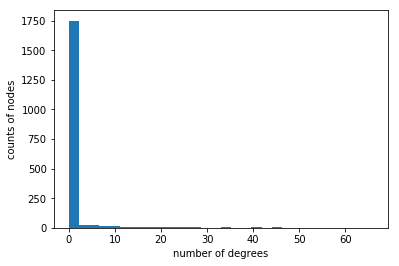

In [ ]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()